In [1]:
!git clone https://github.com/abidlabs/contrastive

fatal: destination path 'contrastive' already exists and is not an empty directory.


In [2]:
pip install contrastive


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1274/2013310257.py:11: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',


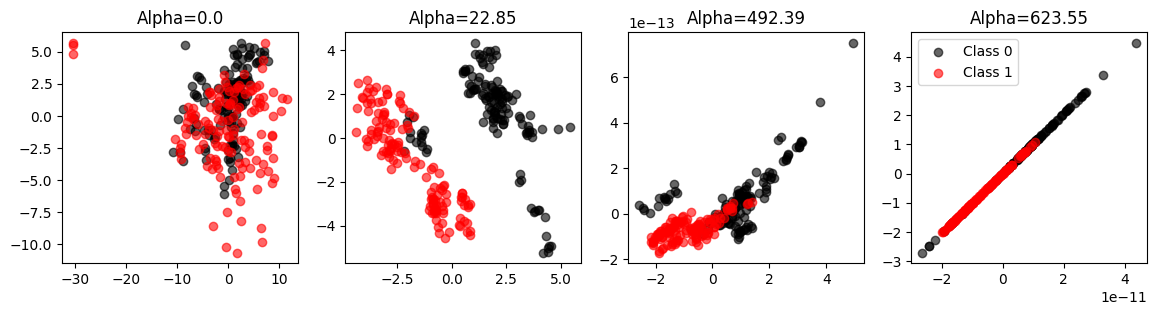

In [3]:
import os,sys,inspect
import numpy as np
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from contrastive import CPCA

DATA_CORTEX_NUCLEAR_FILEPATH = "contrastive/experiments/datasets/Data_Cortex_Nuclear.csv"

classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

data = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)

target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))

target = data[target_idx]

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
background = data[background_idx]

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels)

In [4]:
from sklearn.decomposition import PCA

projected_data_for_training = mdl.fit_transform(target, background, plot=False, active_labels=labels)
pca = PCA(
    n_components=2
)

X_pca_projected_data = pca.fit_transform(target)

print(X_pca_projected_data.shape)


(270, 2)


In [5]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

X_data, y_data = shuffle(X_pca_projected_data, np.array(labels))

for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)
    clf_knn = KNeighborsClassifier(
        n_neighbors=n_neighbors
    )
    count = 0


    for train_index, test_index in kf.split(X_data):
        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = np.array(y_data)[train_index], np.array(y_data)[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.8925925925925926
Val acc std: 0.00740740740740744

n_neighbors = 3
Train acc mean: 0.9564814814814815
Train acc std: 0.007522257782070334
Val acc mean: 0.8518518518518519
Val acc std: 0.03513641844631531

n_neighbors = 5
Train acc mean: 0.9333333333333332
Train acc std: 0.008072035080630865
Val acc mean: 0.8481481481481481
Val acc std: 0.027216552697590855



In [7]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# TODO: When reproducing results, ensure that ALPHAS correspond to the correct values
ALPHAS = [0, 22.85, 492.39, 623.55]
for i in range(len(projected_data_for_training)):
    X_data, y_data = shuffle(projected_data_for_training[i], np.array(labels))
    for n_neighbors in [1, 3, 5]:
        train_accuracies = []
        test_accuracies = []
        kf = KFold(n_splits=5)
        count = 0
        for train_index, test_index in kf.split(X_data):
            # print(train_index, test_index)
            clf_knn = KNeighborsClassifier(
                n_neighbors=n_neighbors
            )
    
            X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
            y_train_k, y_valid_k = y_data[train_index], y_data[test_index]
    
            clf_knn.fit(X_train_k, y_train_k)
            count += 1
            train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
            test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))
    
        print(f"n_neighbors = {n_neighbors}, alpha={ALPHAS[i]}")
        print(f"Train acc mean: {np.mean(train_accuracies)}")
        print(f"Train acc std: {np.std(train_accuracies)}")
        print(f"Val acc mean: {np.mean(test_accuracies)}")
        print(f"Val acc std: {np.std(test_accuracies)}")
        print()

n_neighbors = 1, alpha=0
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.6851851851851851
Val acc std: 0.07219847662821458

n_neighbors = 3, alpha=0
Train acc mean: 0.8444444444444444
Train acc std: 0.023715274953454994
Val acc mean: 0.7148148148148149
Val acc std: 0.0718174793691308

n_neighbors = 5, alpha=0
Train acc mean: 0.8101851851851851
Train acc std: 0.022490662595353914
Val acc mean: 0.7
Val acc std: 0.048855207252862666

n_neighbors = 1, alpha=22.85
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.9666666666666666
Val acc std: 0.024567591039669635

n_neighbors = 3, alpha=22.85
Train acc mean: 0.9898148148148149
Train acc std: 0.00346449758034621
Val acc mean: 0.9740740740740741
Val acc std: 0.014814814814814841

n_neighbors = 5, alpha=22.85
Train acc mean: 0.9842592592592592
Train acc std: 0.002268046058132582
Val acc mean: 0.962962962962963
Val acc std: 0.01656346649999847

n_neighbors = 1, alpha=492.39
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.8333

In [10]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

X_data, y_data = shuffle(X_pca_projected_data, np.array(labels))

for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)
    clf = SVC()
    count = 0


    for train_index, test_index in kf.split(X_data):
        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = np.array(y_data)[train_index], np.array(y_data)[test_index]

        clf.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf.score(X_train_k, y_train_k))
        test_accuracies.append(clf.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 0.8768518518518519
Train acc std: 0.012962962962962957
Val acc mean: 0.8703703703703705
Val acc std: 0.051052032415148975

n_neighbors = 3
Train acc mean: 0.8768518518518519
Train acc std: 0.012962962962962957
Val acc mean: 0.8703703703703705
Val acc std: 0.051052032415148975

n_neighbors = 5
Train acc mean: 0.8768518518518519
Train acc std: 0.012962962962962957
Val acc mean: 0.8703703703703705
Val acc std: 0.051052032415148975



In [8]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
import numpy as np

# TODO: When reproducing results, ensure that ALPHAS correspond to the correct values
ALPHAS = [0, 22.85, 492.39, 623.55]
for i in range(len(projected_data_for_training)):
    X_data, y_data = shuffle(projected_data_for_training[i], np.array(labels))
    for n_neighbors in [1, 3, 5]:
        train_accuracies = []
        test_accuracies = []
        kf = KFold(n_splits=5)
        count = 0
        for train_index, test_index in kf.split(X_data):
            # print(train_index, test_index)
            clf = SVC()
    
            X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
            y_train_k, y_valid_k = y_data[train_index], y_data[test_index]
    
            clf.fit(X_train_k, y_train_k)
            count += 1
            train_accuracies.append(clf.score(X_train_k, y_train_k))
            test_accuracies.append(clf.score(X_valid_k, y_valid_k))
    
        print(f"alpha={ALPHAS[i]}")
        print(f"Train acc mean: {np.mean(train_accuracies)}")
        print(f"Train acc std: {np.std(train_accuracies)}")
        print(f"Val acc mean: {np.mean(test_accuracies)}")
        print(f"Val acc std: {np.std(test_accuracies)}")
        print()

alpha=0
Train acc mean: 0.7259259259259259
Train acc std: 0.017906555190568274
Val acc mean: 0.6962962962962964
Val acc std: 0.07821745215534398

alpha=0
Train acc mean: 0.7259259259259259
Train acc std: 0.017906555190568274
Val acc mean: 0.6962962962962964
Val acc std: 0.07821745215534398

alpha=0
Train acc mean: 0.7259259259259259
Train acc std: 0.017906555190568274
Val acc mean: 0.6962962962962964
Val acc std: 0.07821745215534398

alpha=22.85
Train acc mean: 0.9453703703703704
Train acc std: 0.004536092116265165
Val acc mean: 0.9481481481481481
Val acc std: 0.02456759103966962

alpha=22.85
Train acc mean: 0.9453703703703704
Train acc std: 0.004536092116265165
Val acc mean: 0.9481481481481481
Val acc std: 0.02456759103966962

alpha=22.85
Train acc mean: 0.9453703703703704
Train acc std: 0.004536092116265165
Val acc mean: 0.9481481481481481
Val acc std: 0.02456759103966962

alpha=492.39
Train acc mean: 0.8564814814814815
Train acc std: 0.007746852097537732
Val acc mean: 0.848148148148